In [1]:
import torch
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from model import FullyConnectedVAE, CNNVAE
from main import mnist_transform
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Loading model

In [54]:
# Set `ZDIM`, model class, and model file name same as training phase.
ZDIM = 20

#net = FullyConnectedVAE(28*28, ZDIM).to(device)
net = CNNVAE(1, ZDIM).to(device)
net.load_state_dict(torch.load("cnn_result/model.pt"))
net.eval()

CNNVAE(
  (enc_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
  )
  (enc_mean): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): AdaptiveAvgPool2d(output_size=1)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
  (enc_std): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): AdaptiveAvgPool2d(output_size=1)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=False)
    (1): Lambda()
    (2): ZeroPad2d(padding=(1, 1, 1, 1), 

# Reconstructing images

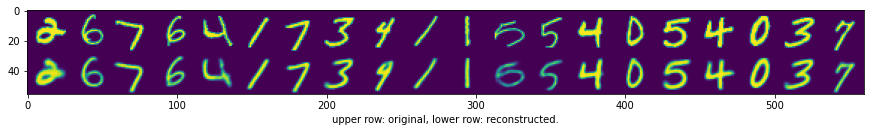

In [55]:
N = 20

test_mnist = MNIST(root=".", download=True, transform=mnist_transform)
test_loader = DataLoader(test_mnist, batch_size=N, shuffle=True)

images, _ = next(iter(test_loader))
with torch.no_grad():
    reconstructed = net(images.to(device)).reshape(-1,28,28).cpu().numpy()
reconstructed = np.concatenate(reconstructed, axis=1)

images = np.concatenate(images.numpy().reshape(-1,28,28), axis=1)

plt.figure(figsize=(15,5))
plt.imshow(np.concatenate([images, reconstructed], axis=0))
plt.xlabel("upper row: original, lower row: reconstructed.")
plt.show()

# Generating images
Generate digits from random vectors sampled from standard normal distribution with decoder.

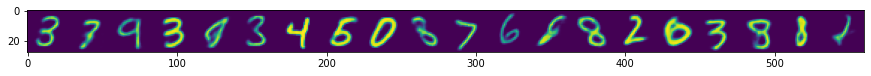

In [56]:
N = 20

with torch.no_grad():
    z = torch.normal(0.0, 1.0, size=(N, ZDIM)).to(device)
    gen_image = net.decode(z).reshape(-1,28,28).cpu().numpy()
gen_image = np.concatenate(gen_image, axis=1)

plt.figure(figsize=(15,5))
plt.imshow(gen_image)
plt.show()

Morphing via linearly interpolating randomly selected two points in the latent space.

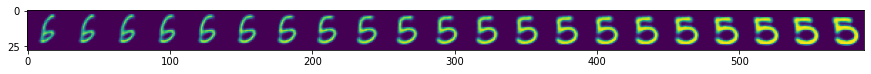

In [92]:
M = 20    # points between z1 and z2

with torch.no_grad():
    z1 = torch.normal(0.0, 1.0, size=(ZDIM,))
    z2 = torch.normal(0.0, 1.0, size=(ZDIM,))

    z = [z1]
    for i in range(1, M):
        alpha = i / M
        z.append((1.0-alpha)*z1 + alpha*z2)
    z.append(z2)

    z = torch.stack(z).to(device)
    images = net.decode(z).reshape(-1,28,28).cpu().numpy()
    
images = np.concatenate(images, axis=1)
plt.figure(figsize=(15,5))
plt.imshow(images)
plt.show()